### Compare forward wavefield and shot gather 
with `damp` or `pml` method

#### Import packages and solver

In [2]:
import numpy as np
from devito import (Grid, TimeFunction, Function, Eq, Operator, div, grad, configuration,solve)
from examples.seismic import RickerSource, Receiver, TimeAxis, plot_velocity, plot_image, plot_shotrecord
from wavesolver_pml import AcousticWaveSolver
from examples.seismic import AcquisitionGeometry
from model_pml import Model

import os
import subprocess
from devito import configuration
configuration['log-level'] = 'DEBUG' 

#### Set the model and parameters

Allocating host memory for dampx0(273, 253) [270 KB]
Allocating host memory for dampx1(273, 253) [270 KB]
Allocating host memory for dampz0(273, 253) [270 KB]
Allocating host memory for dampz1(273, 253) [270 KB]
Allocating host memory for vp(273, 253) [270 KB]


Now using PML
Now using simple damping


Operator `initdamp` generated in 0.36 s
  * lowering.IET: 0.18 s (51.1 %)
     * specializing.IET: 0.10 s (28.4 %)
  * lowering.Clusters: 0.14 s (39.7 %)
     * specializing.Clusters: 0.09 s (25.6 %)
Flops reduction after symbolic optimization: [54 --> 54]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid212010/3bc4a2720ccdbb31dcc37bf5866d38acfae37183.c` in 0.12 s from jit-cache
Operator `initdamp` ran in 0.01 s
Global performance: [OI=0.47, 0.02 GFlops/s]
Local performance:
  * section0 ran in 0.01 s
  * section1 ran in 0.01 s
  * section2 ran in 0.01 s
  * section3 ran in 0.01 s
  * section4 ran in 0.01 s
  * section5 ran in 0.01 s
  * section6 ran in 0.01 s
Performance[mode=advanced] arguments: {'pthreads': 0}
Allocating host memory for vp(273, 253) [270 KB]


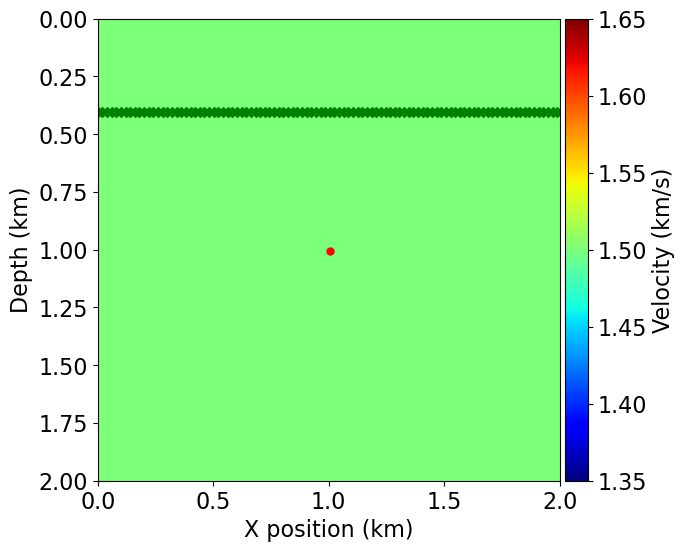

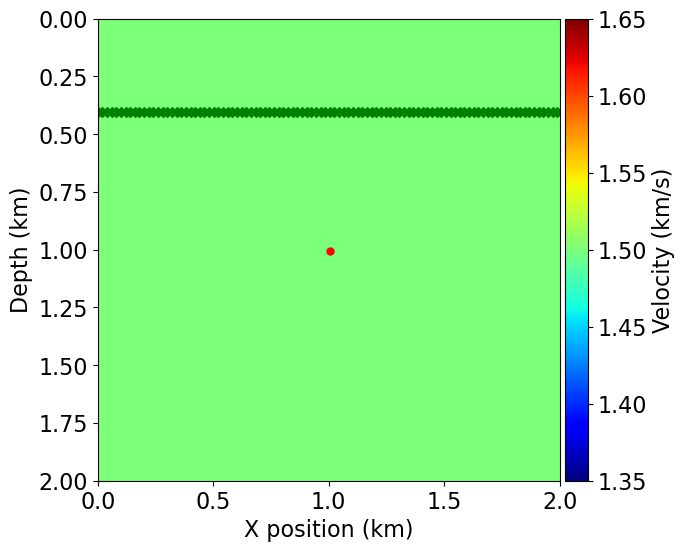

In [3]:
# Create the computational grid
nx, nz = 201, 201       # Number of grid points
dx, dz = 10.0, 10.0     # Grid spacing

shape = (nx, nz)
spacing = (dx, dz)
origin = (0., 0.)

space_order = 16

# Define velocity model v(x)
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:] = 1.5  

nbpml = 20


model_pml = Model(origin=origin, shape=shape,spacing=spacing, 
                vp=v,space_order=space_order, fs=True,
                nbl=nbpml,bcs="pml",pml=True)

model_damp = Model(origin=origin, shape=shape,spacing=spacing,
                vp=v,space_order=space_order, fs=True,
                nbl=nbpml,bcs="damp",pml=False)


# Simulation parameters

nt = 4500               # Number of time steps\
dt = 1                  # Time step size
t0 = 0.                 # Start time
tn = nt * dt            # End time


# Time axis
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# Source
nshots = 1

src_coordinates = np.empty((nshots, 2))
src_coordinates[:, 0] = nx*dx/2 
src_coordinates[:, 1] = nz*dz/2  

# Receiver
n_receivers = 101
rec_coordinates = np.empty((n_receivers, 2))
rec_coordinates[:, 0] = np.linspace(0, nx*dx, num=n_receivers)
rec_coordinates[:, 1] = nz*dz/5

plot_velocity(model_pml, source=src_coordinates, receiver=rec_coordinates)
plot_velocity(model_damp, source=src_coordinates, receiver=rec_coordinates)

#### Create the wavelet and geometry

In [4]:
geometry_pml = AcquisitionGeometry(model_pml, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker')
geometry_damp = AcquisitionGeometry(model_damp, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker')

#### Simulate the shotgather

Operator `initdamp` generated in 0.34 s
  * lowering.IET: 0.17 s (51.2 %)
     * specializing.IET: 0.09 s (27.1 %)
  * lowering.Clusters: 0.13 s (39.1 %)
     * specializing.Clusters: 0.09 s (27.1 %)
Flops reduction after symbolic optimization: [54 --> 54]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid212010/3bc4a2720ccdbb31dcc37bf5866d38acfae37183.c` in 0.03 s from jit-cache
Operator `initdamp` ran in 0.01 s
Global performance: [OI=0.47, 0.02 GFlops/s]
Local performance:
  * section0 ran in 0.01 s
  * section1 ran in 0.01 s
  * section2 ran in 0.01 s
  * section3 ran in 0.01 s
  * section4 ran in 0.01 s
  * section5 ran in 0.01 s
  * section6 ran in 0.01 s
Performance[mode=advanced] arguments: {'pthreads': 0}
Allocating host memory for src_coords(1, 2) [8 B]
Allocating host memory for src(1361, 1) [5 KB]
Allocating host memory for rec_coords(101, 2) [808 B]
Allocating host memory for src_coords(1, 2) [8 B]
Allocating host memory for src(1361, 1) [5 KB]
Allocating host memory fo

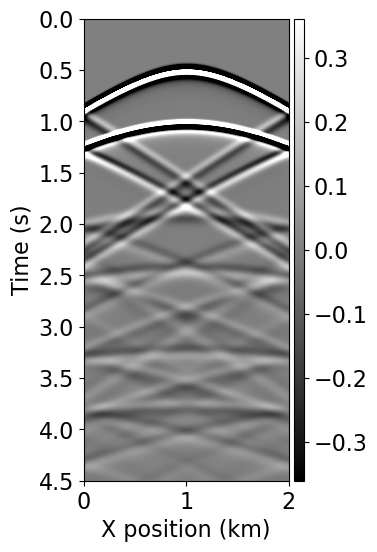

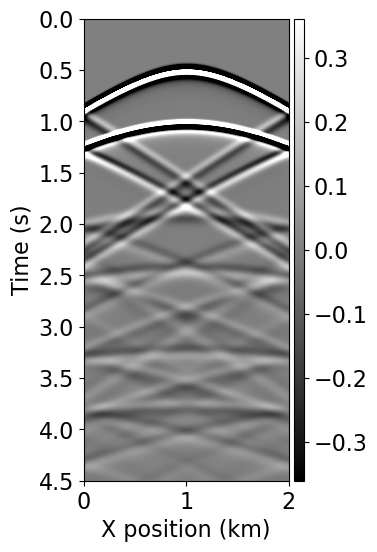

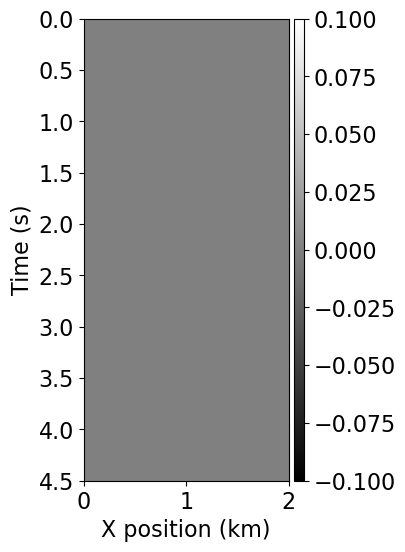

In [5]:
pml_solver = AcousticWaveSolver(model_pml, geometry_pml, space_order=space_order)
Shot_pml, _, _ = pml_solver.forward(model=model_pml)

damp_solver = AcousticWaveSolver(model_damp, geometry_damp, space_order=space_order)
Shot_damp , _, _ = damp_solver.forward(model=model_damp)

## Difference between the two shots
diff_shot = Shot_pml.data - Shot_damp.data
plot_shotrecord(Shot_pml.data, model_pml, t0, tn)
plot_shotrecord(Shot_damp.data, model_damp, t0, tn)
plot_shotrecord(diff_shot, model_pml, t0, tn)

Allocating host memory for src_coords(1, 2) [8 B]
Allocating host memory for src(153, 1) [612 B]
Allocating host memory for rec_coords(101, 2) [808 B]
Allocating host memory for src_coords(1, 2) [8 B]
Allocating host memory for src(153, 1) [612 B]
Allocating host memory for rec_coords(101, 2) [808 B]
Operator `Forward` generated in 3.79 s
  * lowering.Clusters: 2.80 s (74.0 %)
     * specializing.Clusters: 1.10 s (29.1 %)
     * schedule: 0.95 s (25.1 %)
Flops reduction after symbolic optimization: [228 --> 141]
Allocating host memory for rec(153, 101) [60 KB]
Allocating host memory for u(3, 273, 253) [809 KB]
Operator `Forward` fetched `/tmp/devito-jitcache-uid212010/1ac752803a5461c517ac06897b3c80762e1e9de6.c` in 0.07 s from jit-cache
Operator `Forward` ran in 0.03 s
Global performance: [OI=0.24, 15.46 GFlops/s, 0.27 GPts/s]
Global performance <w/o setup>: [0.03 s, 0.33 GPts/s]
Local performance:
  * section0 ran in 0.01 s
  * section1 ran in 0.03 s [OI=0.24, 19.12 GFlops/s, 0.34 GPts

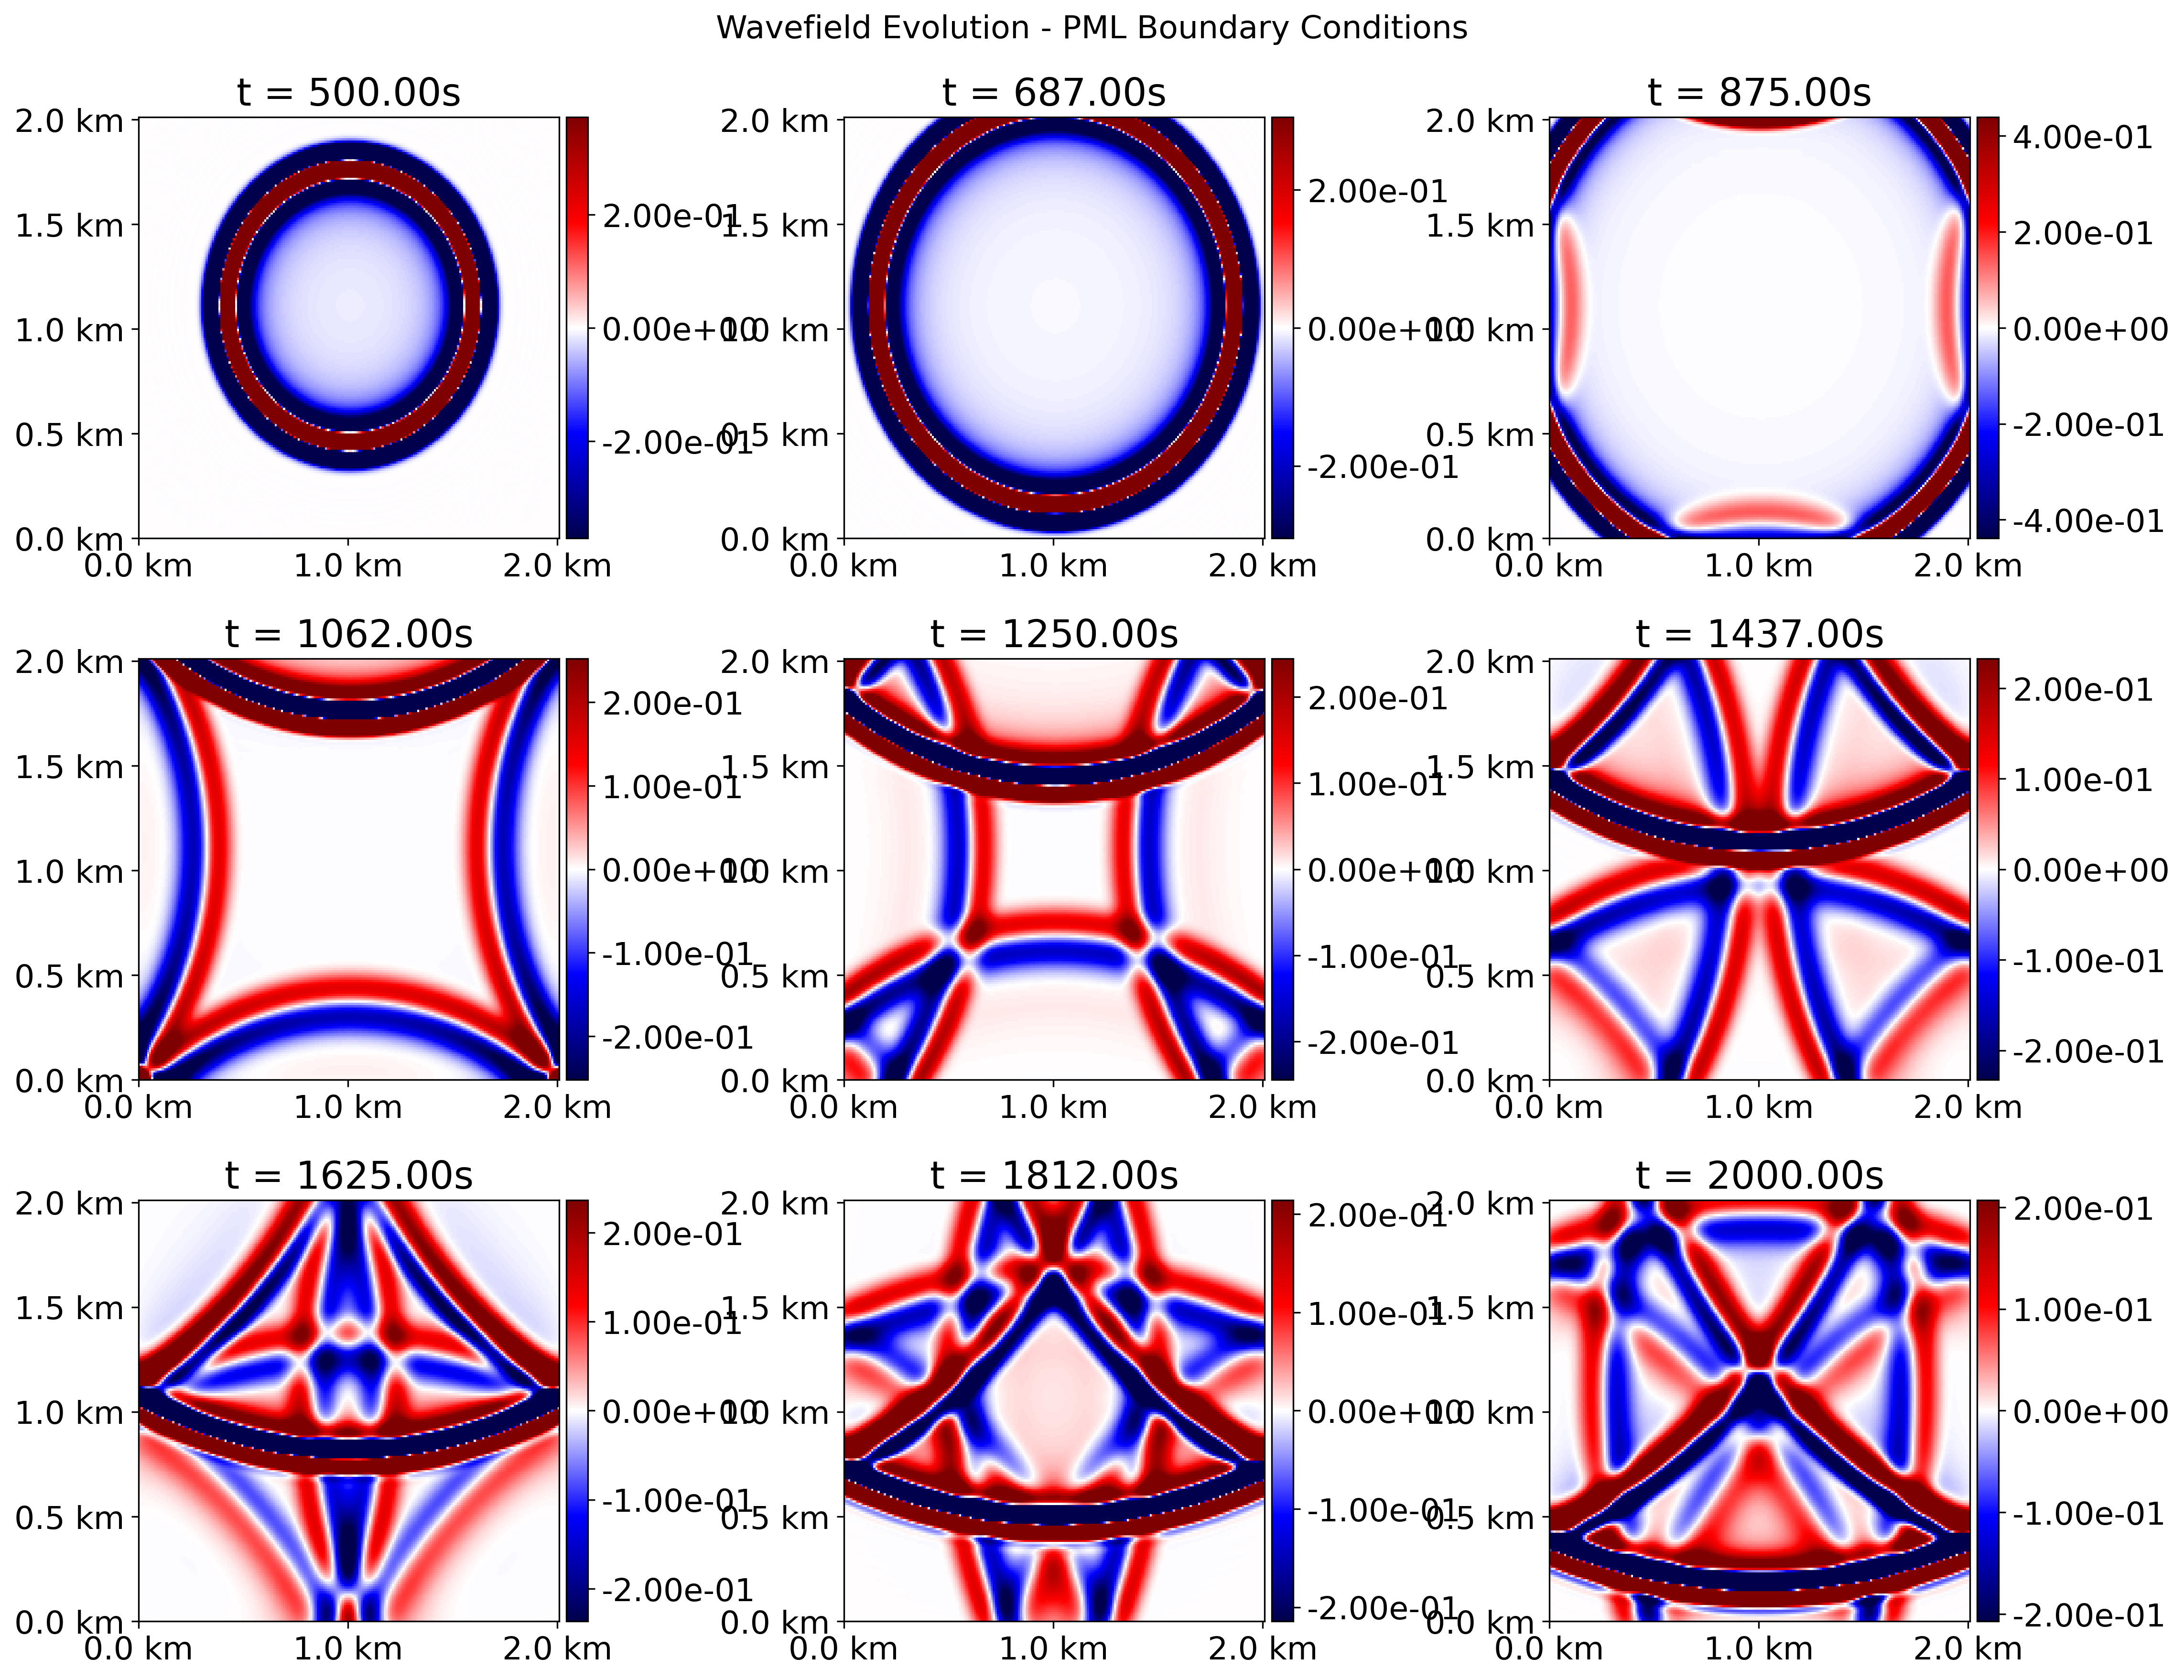

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
def graph2d(U, ax, fig, dx, dz, nx, nz, nbpml,freesurface=False):
    """
    Plots the wavefield U on the given Axes and Figure.
    Before plotting, use
    ====================
    fig,ax = plt.subplots()
    ====================
    Parameters:
    - U (numpy.ndarray): Wavefield data to plot.
    - ax (matplotlib.axes.Axes): The axes to plot on.
    - fig (matplotlib.figure.Figure): The figure containing the axes.
    - dx (float): Grid spacing in x-direction.
    - dz (float): Grid spacing in z-direction.
    - nx (int): Number of grid points in x-direction.
    - nz (int): Number of grid points in z-direction.
    - nbpml (int): Number of PML layers.

    Returns:
    - img: The image object created by imshow.
    """
    ax.clear()  # Clear previous data

    fscale = 1 / 10**3
    # Calculate the scale based on the maximum value in the wavefield

   
    max_val = np.amax(U[nbpml:-nbpml, 0:-nbpml])
    min_val = np.amin(U[nbpml:-nbpml, 0:-nbpml])
    scale = max(abs(max_val), abs(min_val)) / 10.

    # Define the extent of the plot in kilometers
    extent = [
        fscale * 0,
        fscale * (nx  * dx),
        fscale * (nz * dx),
        fscale * 0
    ]
    if freesurface==True:
        # Plot the wavefield
        img = ax.imshow(
            np.transpose(U[nbpml:-nbpml, 0:-nbpml]),
            vmin=-scale,
            vmax=scale,
            cmap=cm.seismic,
            extent=extent,
            origin='lower'
            )
    else:
        # Plot the wavefield
        img = ax.imshow(
            np.transpose(U[nbpml:-nbpml, nbpml:-nbpml]),
            vmin=-scale,
            vmax=scale,
            cmap=cm.seismic,
            extent=extent,
            origin='lower'
            )
    # Ensure the Y-axis points downward for seismic data (depth increases downward)
    ax.invert_yaxis()
    # Format the axes to display in kilometers
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f km'))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f km'))
    ax.axis('equal')  # Ensure equal scaling
    ax.set_title('Map - Acoustic Problem PML Devito')

    # Manage the colorbar
    if not hasattr(ax, 'cax'):
        divider = make_axes_locatable(ax)
        ax.cax = divider.append_axes("right", size="5%", pad=0.05)
    else:
        ax.cax.clear()

    cbar = fig.colorbar(img, cax=ax.cax, format='%.2e')
    #cbar.set_label('Displacement [km]')

    return img

def plot_wavefield_3x3_grid(model, src_coordinates, rec_coordinates, 
                          nt, dt, nbpml, space_order, model_type="PML", 
                          figsize=(15, 12), dpi=300):
    """
    Plot a 3x3 grid of wavefields at different time steps.
    
    Parameters:
    -----------
    model: Model object (model_pml or model_damp)
    model_type: str, "PML" or "DAMP" to indicate model type in title
    """
    # Create a figure with 3x3 grid
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = GridSpec(3, 3, figure=fig)
    axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(3)]
    
    # Calculate time steps to display (9 equally spaced points)
    start_idx = 500  # Start from a time when wave has propagated
    end_idx = min(nt - 100, 2000)  # End before the end of simulation
    time_indices = np.linspace(start_idx, end_idx, 9, dtype=int)
    
    # Loop through each subplot
    for idx, (ax, time_idx) in enumerate(zip(axes, time_indices)):
        # Reset time parameters for the specific time step
        t0 = 0.
        tn = time_idx * dt
        
        # Setup acquisition geometry for this time step
        geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                                      t0, tn, f0=0.010, src_type='Ricker')
        
        # Create solver and compute wavefield
        solver = AcousticWaveSolver(model, geometry, space_order=space_order)
        _, U, _ = solver.forward(model=model)
        
        # Plot the wavefield
        graph2d(U.data[-1], ax, fig, *model.spacing, *model.shape, nbpml)
        ax.set_title(f't = {tn:.2f}s')
    
    # Add a main title
    fig.suptitle(f'Wavefield Evolution - {model_type} Boundary Conditions', 
                fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Return the figure for display
    return fig

# Example usage:
# For PML model
fig_pml = plot_wavefield_3x3_grid(model_pml, src_coordinates, rec_coordinates,
                                nt=nt, dt=dt, nbpml=nbpml, 
                                space_order=space_order, model_type="PML")

# For damped boundary model
#fig_damp = plot_wavefield_3x3_grid(model_damp, src_coordinates, rec_coordinates,
#                                 nt=nt, dt=dt, nbpml=nbpml, 
#                                 space_order=space_order, model_type="Damping")

Allocating host memory for src_coords(1, 2) [8 B]
Allocating host memory for src(153, 1) [612 B]
Allocating host memory for rec_coords(101, 2) [808 B]
Allocating host memory for src_coords(1, 2) [8 B]


Allocating host memory for src(153, 1) [612 B]
Allocating host memory for rec_coords(101, 2) [808 B]
Operator `Forward` generated in 3.75 s
  * lowering.Clusters: 2.88 s (77.0 %)
     * specializing.Clusters: 1.36 s (36.4 %)
        * fuse: 0.86 s (23.0 %)
Flops reduction after symbolic optimization: [228 --> 141]
Allocating host memory for rec(153, 101) [60 KB]
Allocating host memory for u(3, 273, 253) [809 KB]
Operator `Forward` fetched `/tmp/devito-jitcache-uid212010/74143d82ee5d74cdae4320a939125e68d71e76e7.c` in 0.07 s from jit-cache
Operator `Forward` ran in 0.03 s
Global performance: [OI=0.24, 15.46 GFlops/s, 0.27 GPts/s]
Global performance <w/o setup>: [0.03 s, 0.32 GPts/s]
Local performance:
  * section0 ran in 0.01 s
  * section1 ran in 0.03 s [OI=0.24, 18.34 GFlops/s, 0.32 GPts/s]
  * section2 ran in 0.01 s
  * section3 ran in 0.01 s
Performance[mode=advanced] arguments: {'pthreads': 0}
Allocating host memory for src_coords(1, 2) [8 B]
Allocating host memory for src(209, 1) [

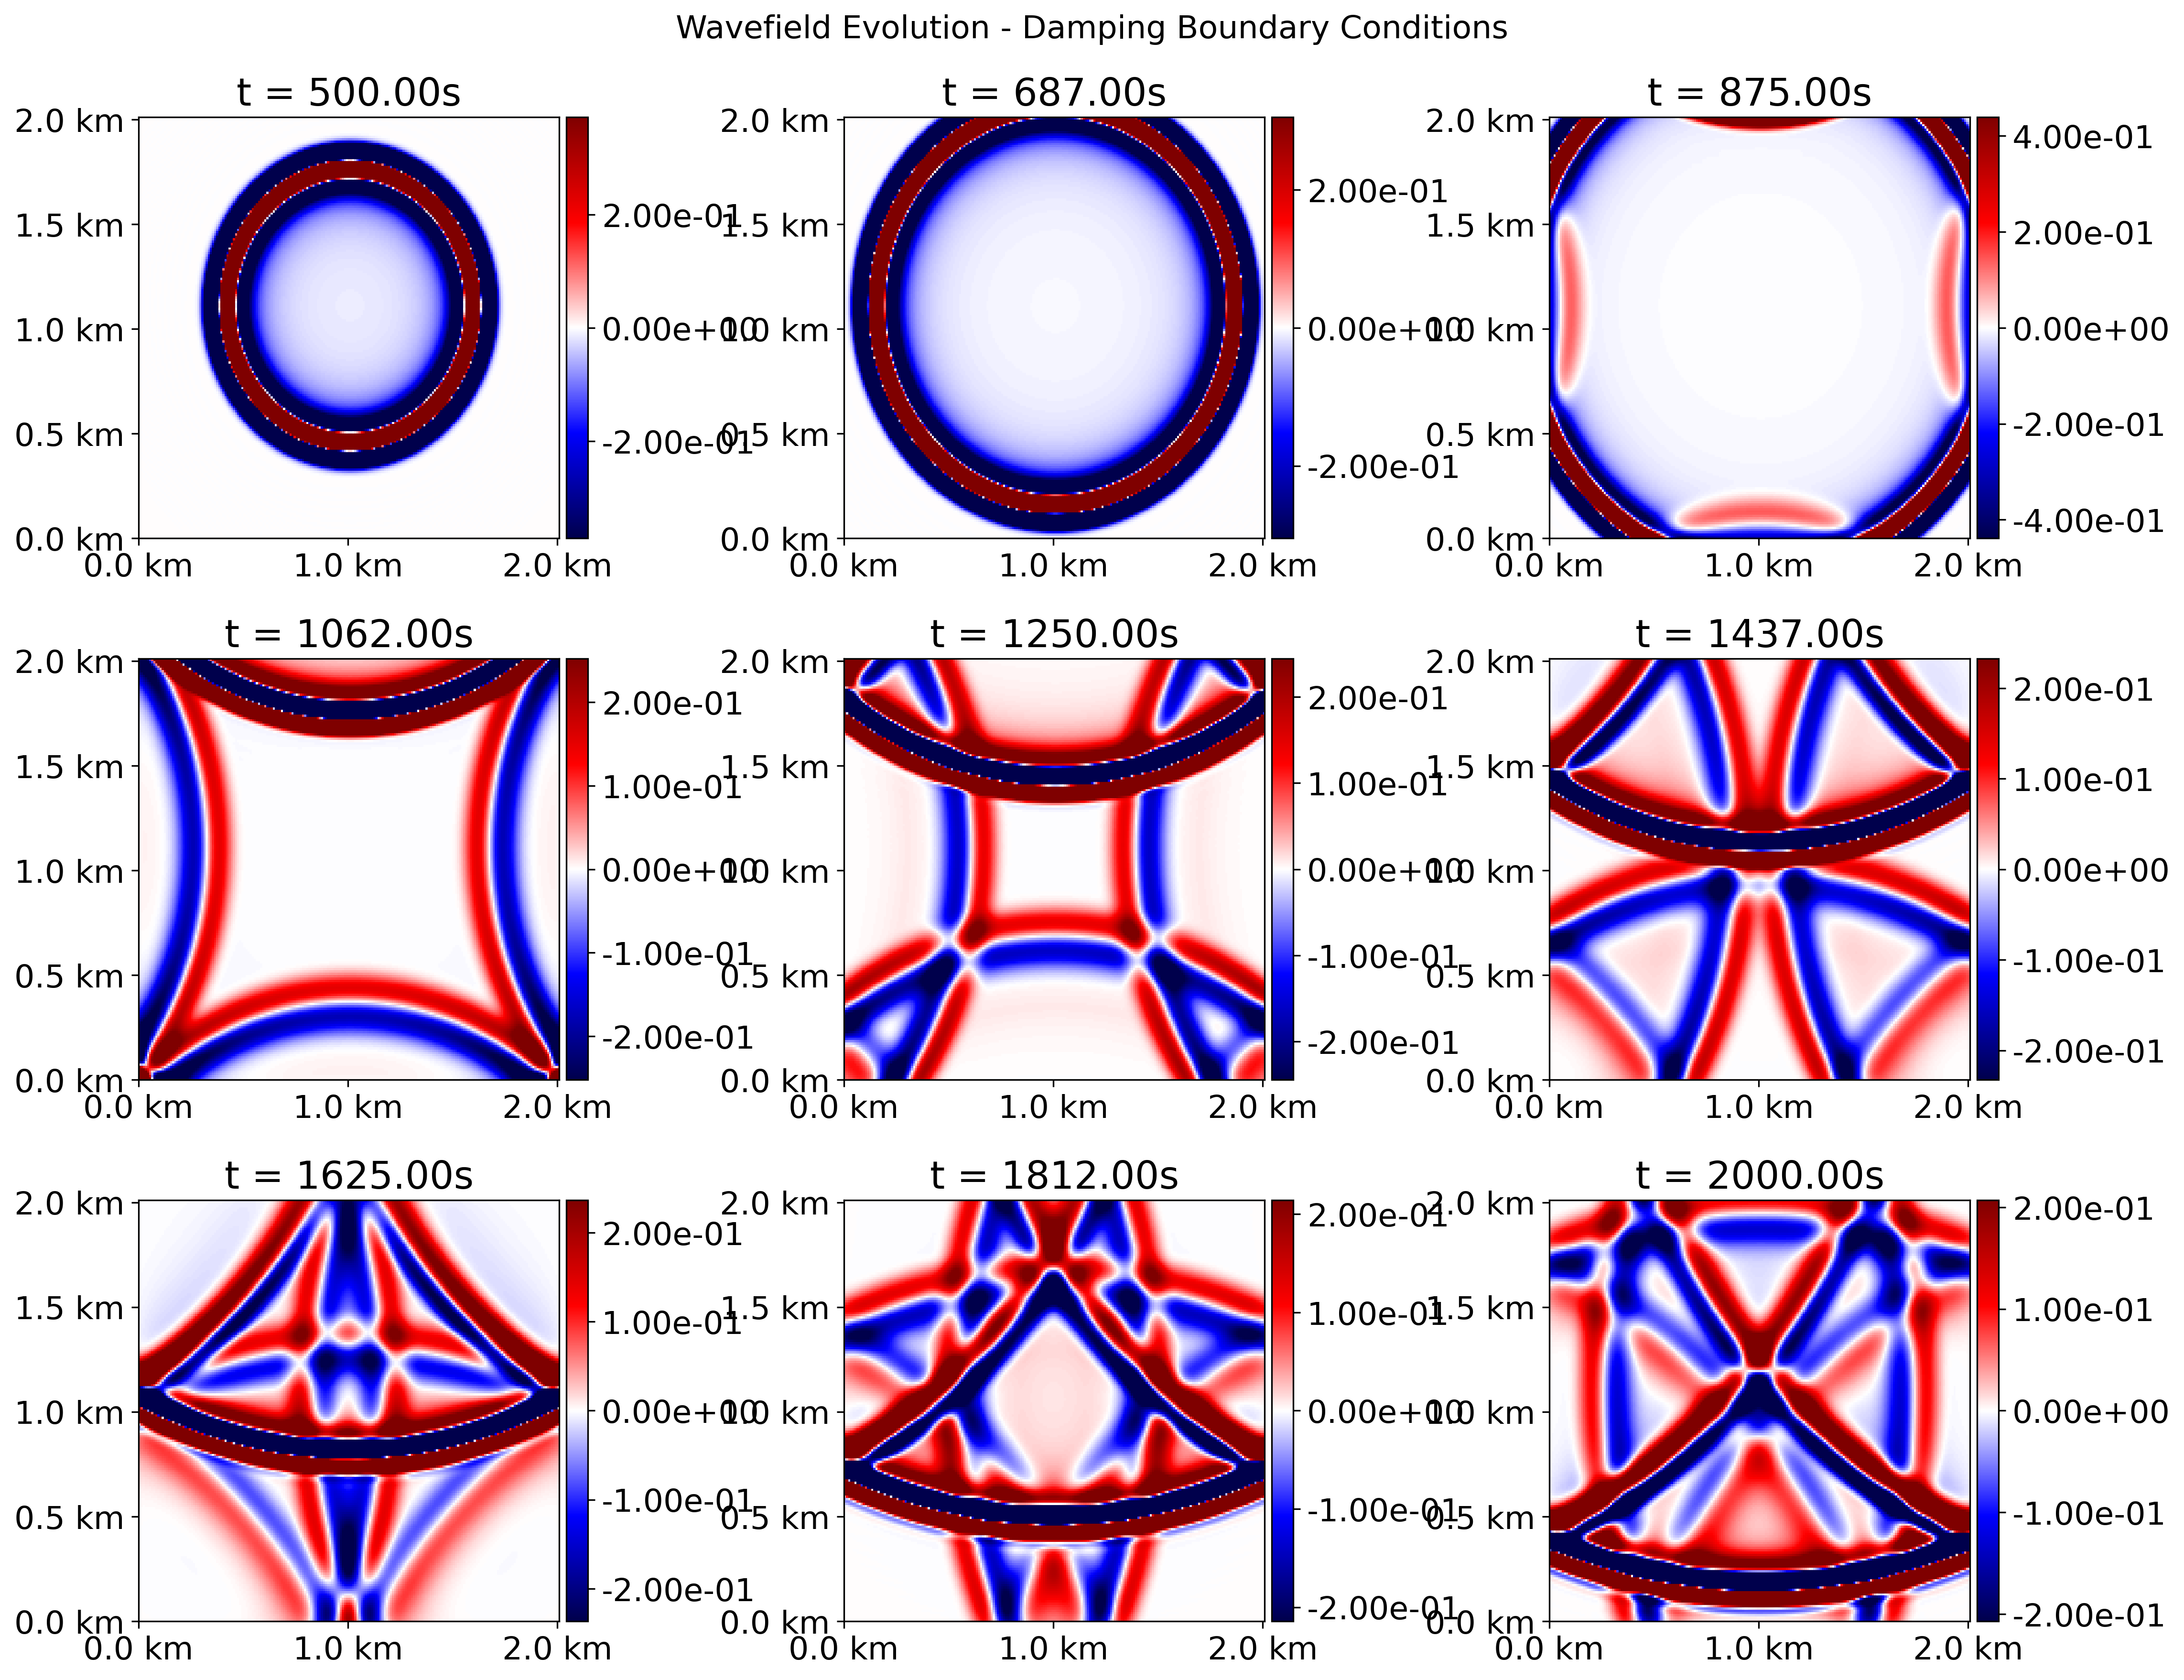

In [7]:
fig_damp = plot_wavefield_3x3_grid(model_damp, src_coordinates, rec_coordinates,
                                 nt=nt, dt=dt, nbpml=nbpml, 
                                 space_order=space_order, model_type="Damping")